In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import partial_trace
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

### Basic Cicuit Model:

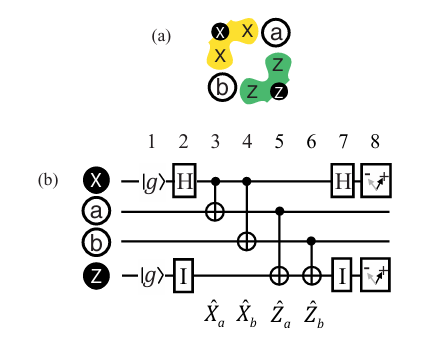

In [2]:
cycles = 6

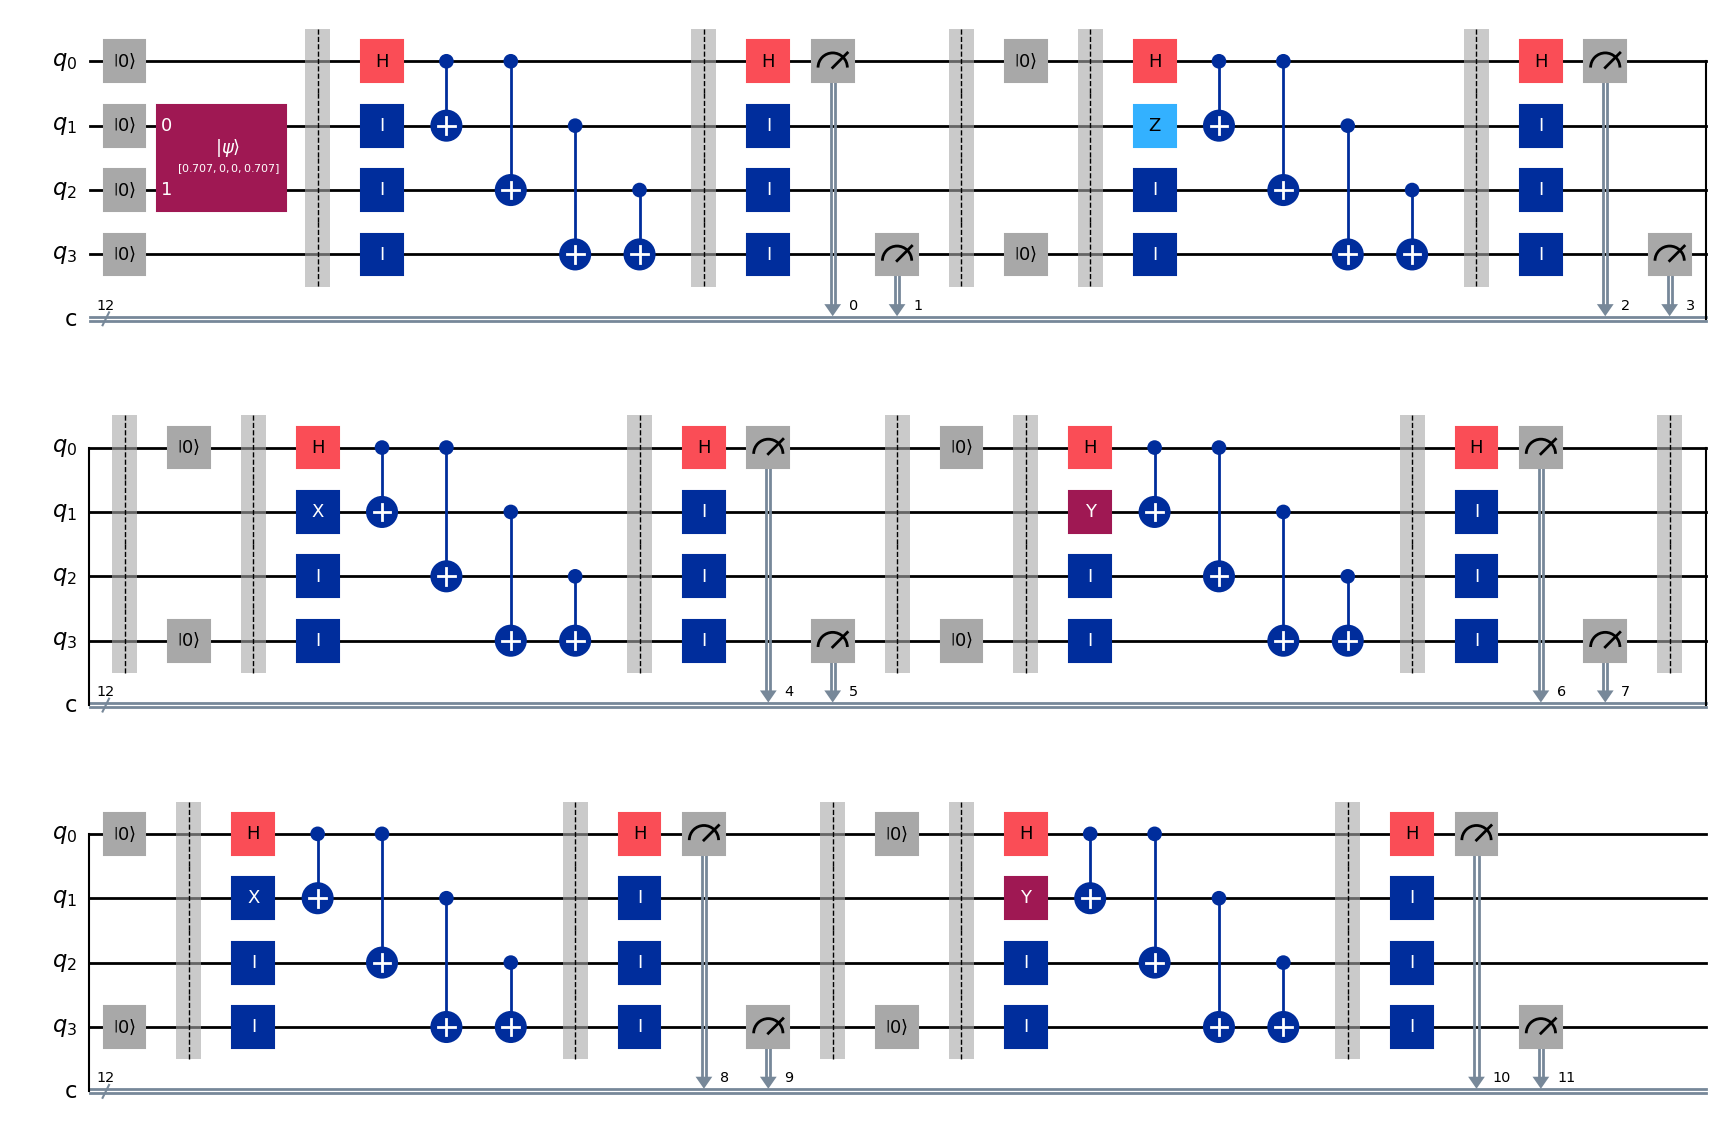

In [3]:
qc = QuantumCircuit(4, cycles*2)
# Define the arbitrary entangled 2-qubit state
A = 1/2
B = 0
C = 0
D = 1/2
errorX_cycle = [2,4]
errorY_cycle = [3,5]
errorZ_cycle = [1]
# Define custom entangled state
A, B, C, D = 1, 0, 0, 1
state_vector = np.array([A, B, C, D])
norm = np.linalg.norm(state_vector)
state_vector = state_vector / norm

# Reset q1 and q2 (qubit indices 1 and 2)
qc.reset(1)
qc.reset(2)
qc.reset(0)
qc.reset(3)

qc.initialize(state_vector, [1, 2])



for i in range(cycles):
    qc.barrier()
    if(i in errorX_cycle):
        qc.h(0)
        qc.x(1)
        qc.id(2)
        qc.id(3) 
    elif (i in errorY_cycle):
        qc.h(0)
        qc.y(1)
        qc.id(2)
        qc.id(3)
    elif (i in errorZ_cycle):
        qc.h(0)
        qc.z(1)
        qc.id(2)
        qc.id(3)
    else: 
        qc.h(0)
        qc.id(1)
        qc.id(2)
        qc.id(3)
         
    # Apply CNOT gates as per the circuit diagram
    qc.cx(0, 1)  # CNOT from qubit 0 to qubit 1
    qc.cx(0, 2)  # CNOT from qubit 0 to qubit 2
    qc.cx(1, 3)  # CNOT from qubit 2 to qubit 1
    qc.cx(2, 3)  # CNOT from qubit 2 to qubit 3
    qc.barrier()
    # Apply Identity (I) on qubit 3 (corresponding to |lg>) - no explicit gate needed

    # Apply Hadamard gate on qubit 0 before measurement in the X basis
    qc.h(0)
    qc.id(1)
    qc.id(2)
    qc.id(3)

    # Measure qubits in the X and Z bases
    qc.measure(0, 2*i)  # X_a measurement
    qc.measure(3, 2*i+1)  # Z_b measurement

    
    if (i != cycles-1):
        # Reset qubits q0 and q3 to |0⟩ state
        qc.barrier()
        qc.reset(0)  # Reset q0
        qc.reset(3)  # Reset q3
    


# Draw the circuit
qc.draw("mpl")

In [4]:
simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(qc, simulator)
job = simulator.run(transpiled_circuit, shots=1)
result = job.result()
counts = result.get_counts()


# Process and analyze results
def analyze_results(counts, cycles):
    x_results = {}
    z_results = {}

    for bitstring, count in counts.items():
        bitstring = bitstring[::-1]  # Reverse Qiskit bit order

        x_key = tuple(bitstring[2*i] for i in range(cycles))     # Even indices: 0,2,...
        z_key = tuple(bitstring[2*i + 1] for i in range(cycles)) # Odd indices: 1,3,...

        x_results[x_key] = x_results.get(x_key, 0) + count
        z_results[z_key] = z_results.get(z_key, 0) + count

    # Make string versions for display
    x_results_str = {','.join(key): val for key, val in x_results.items()}
    z_results_str = {','.join(key): val for key, val in z_results.items()}
    
    return x_results_str, z_results_str

x_results, z_results = analyze_results(counts, cycles)

print("Results for X measurement Qubits (0,2,4,...):")
for key, val in x_results.items():
    print(f"{key}: {val} shots ({val/1024*100:.2f}%)")

print("\nResults for Z measurement Qubits (1,3,5,...):")
for key, val in z_results.items():
    print(f"{key}: {val} shots ({val/1024*100:.2f}%)")

# Extract bitstring from single-shot result
bitstring = list(counts.keys())[0][::-1]  # Reverse Qiskit bit order

# Split into X and Z measurement values
x_values = [int(bitstring[2*i]) for i in range(cycles)]
z_values = [int(bitstring[2*i + 1]) for i in range(cycles)]

# Cycle steps (timeline)
cycle_range = list(range(1, cycles + 1))





Results for X measurement Qubits (0,2,4,...):
0,1,1,0,0,1: 1 shots (0.10%)

Results for Z measurement Qubits (1,3,5,...):
0,0,1,0,1,0: 1 shots (0.10%)


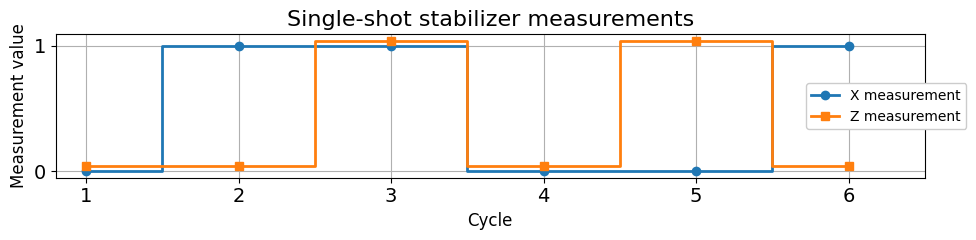

In [ ]:
# Plot
plt.figure(figsize=(10, 2.5))

# Increased linewidth and marker size
plt.step(cycle_range, x_values, where='mid', label='X measurement', marker='o', linewidth=2, markersize=6)
plt.step(cycle_range, z_values, where='mid', label='Z measurement', marker='s', linewidth=2, markersize=6)

# Font size settings
plt.xticks(cycle_range, fontsize=14)
plt.yticks([0, 1], fontsize=14)
plt.xlabel('Cycle', fontsize=12)
plt.ylabel('Measurement value', fontsize=12)
plt.xlim(0.8,6.5)
plt.title('Single-shot stabilizer measurements', fontsize=16)

plt.grid(True)
plt.legend(fontsize=10, bbox_to_anchor=(0.855, 0.5), framealpha=1)
plt.tight_layout()
plt.show()

Measurement results: {'011000110100': 1}


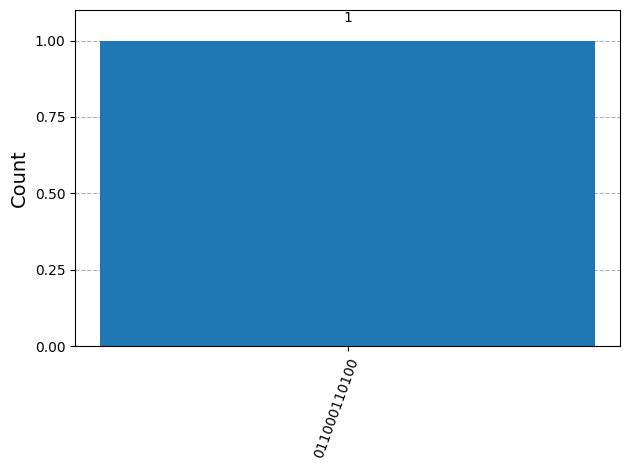

In [6]:
# Choose the simulator
simulator = Aer.get_backend('qasm_simulator')

# Transpile the circuit for the simulator
transpiled_circuit = transpile(qc, simulator)

# Run the simulation
job = simulator.run(transpiled_circuit, shots=1)

# Get results
result = job.result()
counts = result.get_counts()

# Print and plot results
print("Measurement results:", counts)
plot_histogram(counts)

In [7]:

# Initialize circuit
init_circuit = QuantumCircuit(4)
init_circuit.initialize([0, 1], 1)  # Initialize qubit 1 to |1⟩
init_circuit.initialize([0, 1], 2)  # Initialize qubit 2 to |1⟩
init_circuit.draw()
# Get the statevector after initialization
simulator = Aer.get_backend('statevector_simulator')
init_statevector = simulator.run(init_circuit).result().get_statevector()

# Create the main computation circuit for subsequent runs
main_circuit = QuantumCircuit(4, 2)
main_circuit.h(0)
main_circuit.cx(0, 1)
main_circuit.cx(0, 2)
main_circuit.cx(1, 3)
main_circuit.cx(2, 3)
main_circuit.h(0)
main_circuit.measure([0, 3], [0, 1])
main_circuit.draw()

# For subsequent runs, initialize from the saved state
# Create a circuit that starts from our saved state
subsequent_circuit = QuantumCircuit(4, 2)
subsequent_circuit.initialize(init_statevector, range(4))
# Add reset operations for qubits 0 and 3
subsequent_circuit.reset(0)
subsequent_circuit.reset(3)
# Add the main computation
subsequent_circuit = subsequent_circuit.compose(main_circuit)
subsequent_circuit.draw()

# Run the circuit
qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(subsequent_circuit).result()
counts = result.get_counts()
print("Results:", counts)



Results: {'01': 480, '00': 544}


In [8]:
def full_quantum_protocol(A, B, C, D, num_shots=1024):
    """
    Implement the full quantum protocol as described in the paper.
    
    Args:
        A, B, C, D: Complex coefficients for the initial state of data qubits
        num_shots: Number of times to run the circuit
        
    Returns:
        The quantum circuit, simulation results, and analysis of outcomes
    """
    # Create a 4-qubit circuit with 2 classical bits for measurement
    qc = QuantumCircuit(4, 2)
    
    # Normalize the coefficients
    norm = np.sqrt(np.abs(A)**2 + np.abs(B)**2 + np.abs(C)**2 + np.abs(D)**2)
    A, B, C, D = A/norm, B/norm, C/norm, D/norm
    
    # Define qubit indices:
    # q[0] = measure-X qubit, q[1] = data qubit a
    # q[2] = data qubit b, q[3] = measure-Z qubit
    
    # Step 1: Initialize data qubits in the specified state
    # |ψab⟩ = A|gg⟩ + B|ge⟩ + C|eg⟩ + D|ee⟩
    # and measurement qubits in ground state
    full_state = np.zeros(16, dtype=complex)
    full_state[0] = A  # |gggg⟩ = |g⟩⊗|g⟩⊗|g⟩⊗|g⟩
    full_state[2] = B  # |ggeg⟩ = |g⟩⊗|g⟩⊗|e⟩⊗|g⟩
    full_state[4] = C  # |gegg⟩ = |g⟩⊗|e⟩⊗|g⟩⊗|g⟩
    full_state[6] = D  # |geeg⟩ = |g⟩⊗|e⟩⊗|e⟩⊗|g⟩
    
    qc.initialize(full_state, [0, 1, 2, 3])
    
    # Step 2: Apply Hadamard to measure-X qubit (q[0])
    qc.h(0)
    
    # Step 3: First CNOT - control: measure-X (q[0]), target: data qubit a (q[1])
    qc.cx(0, 1)
    
    # Step 4: Second CNOT - control: measure-X (q[0]), target: data qubit b (q[2])
    qc.cx(0, 2)
    
    # Step 5: Third CNOT - control: data qubit a (q[1]), target: measure-Z (q[3])
    qc.cx(1, 3)
    
    # Step 6: Fourth CNOT - control: data qubit b (q[2]), target: measure-Z (q[3])
    qc.cx(2, 3)
    
    # Step 7: Apply second Hadamard to measure-X qubit (q[0])
    qc.h(0)
    
    # Step 8: Measure both qubits
    qc.measure(0, 0)  # Measure-X qubit
    qc.measure(3, 1)  # Measure-Z qubit
    
    # Simulate the circuit
    simulator = Aer.get_backend('aer_simulator')
    transpiled_circuit = transpile(qc, simulator)
    result = simulator.run(transpiled_circuit, shots=num_shots).result()
    counts = result.get_counts()
    
    # Analyze measurement outcomes according to equation B9
    outcomes = {
        '00': '|gg⟩ + |ee⟩',  # {+1, +1} outcome (00 in binary)
        '10': '|gg⟩ - |ee⟩',  # {-1, +1} outcome (10 in binary)
        '01': '|ge⟩ + |eg⟩',  # {+1, -1} outcome (01 in binary)
        '11': '|ge⟩ - |eg⟩',  # {-1, -1} outcome (11 in binary)
    }
    
    # Convert to more readable format
    readable_counts = {}
    for bitstring, count in counts.items():
        # In Qiskit, the rightmost bit corresponds to the first qubit in the register
        # We need to reverse to match the convention in the equations
        measurement_outcome = bitstring[::-1]
        data_state = outcomes[measurement_outcome]
        outcome_label = f"{measurement_outcome} → {data_state}"
        readable_counts[outcome_label] = count
    
    return qc, counts, readable_counts

def analyze_full_protocol_steps(A, B, C, D):
    """
    Analyze the quantum state at each step of the protocol.
    
    Args:
        A, B, C, D: Complex coefficients for the initial state
        
    Returns:
        Dictionary of states at each step
    """
    # Create a statevector simulator
    simulator = Aer.get_backend('statevector_simulator')
    
    # Analyze each step of the protocol
    states = []
    
    # Step 1: Initial state
    qc1 = QuantumCircuit(4)
    norm = np.sqrt(np.abs(A)**2 + np.abs(B)**2 + np.abs(C)**2 + np.abs(D)**2)
    A, B, C, D = A/norm, B/norm, C/norm, D/norm
    
    full_state = np.zeros(16, dtype=complex)
    full_state[0] = A  # |gggg⟩
    full_state[2] = B  # |ggeg⟩
    full_state[4] = C  # |gegg⟩
    full_state[6] = D  # |geeg⟩
    qc1.initialize(full_state, [0, 1, 2, 3])
    
    result1 = simulator.run(qc1).result()
    statevector1 = result1.get_statevector()
    states.append(("Step 1 (Initial state)", statevector1))
    
    # Step 2: After Hadamard on measure-X
    qc2 = qc1.copy()
    qc2.h(0)
    result2 = simulator.run(qc2).result()
    statevector2 = result2.get_statevector()
    states.append(("Step 2 (After Hadamard on measure-X)", statevector2))
    
    # Step 3: After first CNOT
    qc3 = qc2.copy()
    qc3.cx(0, 1)
    result3 = simulator.run(qc3).result()
    statevector3 = result3.get_statevector()
    states.append(("Step 3 (After CNOT: measure-X → data qubit a)", statevector3))
    
    # Step 4: After second CNOT
    qc4 = qc3.copy()
    qc4.cx(0, 2)
    result4 = simulator.run(qc4).result()
    statevector4 = result4.get_statevector()
    states.append(("Step 4 (After CNOT: measure-X → data qubit b)", statevector4))
    
    # Step 5: After third CNOT
    qc5 = qc4.copy()
    qc5.cx(1, 3)
    result5 = simulator.run(qc5).result()
    statevector5 = result5.get_statevector()
    states.append(("Step 5 (After CNOT: data qubit a → measure-Z)", statevector5))
    
    # Step 6: After fourth CNOT
    qc6 = qc5.copy()
    qc6.cx(2, 3)
    result6 = simulator.run(qc6).result()
    statevector6 = result6.get_statevector()
    states.append(("Step 6 (After CNOT: data qubit b → measure-Z)", statevector6))
    
    # Step 7: After final Hadamard on measure-X
    qc7 = qc6.copy()
    qc7.h(0)
    result7 = simulator.run(qc7).result()
    statevector7 = result7.get_statevector()
    states.append(("Step 7 (After final Hadamard on measure-X)", statevector7))
    
    return states

# Example usage with specific coefficients
A = 0.5
B = 0.5
C = 0.5
D = 0.5

# Run the full protocol
circuit, counts, readable_counts = full_quantum_protocol(A, B, C, D)

# Print the circuit
print("Quantum Circuit:")
print(circuit)

# Print measurement results
print("\nRaw Measurement Results:")
print(counts)

print("\nInterpreted Results:")
for outcome, count in readable_counts.items():
    print(f"{outcome}: {count} shots")

# Analyze the states at each step
states = analyze_full_protocol_steps(A, B, C, D)

# Print the state at each step (focusing on non-zero amplitudes)
print("\nState Analysis at Each Step:")
for label, statevector in states:
    print(f"\n{label}:")
    significant_amplitudes = []
    
    for i, amplitude in enumerate(statevector):
        if abs(amplitude) > 1e-10:  # Filter out near-zero amplitudes
            # Convert index to binary representation for qubit states
            binary = format(i, '04b')
            state_label = "|"
            for bit in binary:
                state_label += "g" if bit == "0" else "e"
            state_label += "⟩"
            significant_amplitudes.append((state_label, amplitude))
    
    # Sort by state label for readability
    significant_amplitudes.sort()
    for state_label, amplitude in significant_amplitudes:
        print(f"{state_label}: {amplitude:.4f}")

Quantum Circuit:
     ┌──────────────────────────────────────────────────────┐┌───┐          »
q_0: ┤0                                                     ├┤ H ├──■────■──»
     │                                                      │└───┘┌─┴─┐  │  »
q_1: ┤1                                                     ├─────┤ X ├──┼──»
     │  Initialize(0.5,0,0.5,0,0.5,0,0.5,0,0,0,0,0,0,0,0,0) │     └───┘┌─┴─┐»
q_2: ┤2                                                     ├──────────┤ X ├»
     │                                                      │          └───┘»
q_3: ┤3                                                     ├───────────────»
     └──────────────────────────────────────────────────────┘               »
c: 2/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐     ┌─┐   
«q_0: ┤ H ├─────┤M├───
«     └───┘     └╥┘   
«q_1: ──■────────╫────
«       │        ║    
«q_2: ──┼─

C:\Users\npace\AppData\Local\Temp\ipykernel_60532\3135836354.py:188: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amplitude in enumerate(statevector):


BLABLA

In [9]:
def tensor1(A,B,C,D):
    return np.kron(A, np.kron(B, np.kron(C,D)))

In [10]:
def tensor2(A,B,C):
    return np.kron(A, np.kron(B,C))

In [11]:
def CNOT_1_3(state):
    """
    Apply CNOT with qubit 1 as control and qubit 3 as target
    """
    # CNOT matrix (control qubit is the first qubit, target is the second)
    CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
    ]) 
    # Reshape into multidimensional array
    reshaped = state.reshape(2, 2, 2, 2)
    
    # Swap axes to bring control and target together (qubit order: 0,2,1,3 → 0,2,3,1)
    swapped = np.swapaxes(reshaped, 1, 3)
    
    # Flatten to apply CNOT
    flat_swapped = swapped.reshape(4, 4)
    
    # Apply CNOT
    result = (np.kron(CNOT, np.eye(1)) @ flat_swapped.flatten()).reshape(4, 4)
    
    # Swap back and reshape
    result_swapped = np.swapaxes(result.reshape(2, 2, 2, 2), 1, 3)
    
    return result_swapped.reshape(16)

In [12]:
# Define the arbitrary state |ψ⟩ = α|0⟩ + β|1⟩
A =0  # Example: α = 1/√2
B = 1    # Example: β = 1/√2
arbitrary_state1 = [A, B]  # Statevector representation
C = 0  # Example: α = 1/√2
D = 1   # Example: β = 1/√2
arbitrary_state2 = [C, D]  # Statevector representation

measure_X = [1,0]
measure_Z = [1,0]

# Hadamard matrix
H = (1/np.sqrt(2)) * np.array([
    [1, 1],
    [1, -1]
])
I = np.array([
    [1, 0],
    [0, 1]
])
# CNOT matrix (control qubit is the first qubit, target is the second)
CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
#Initial_state
psi_1 = tensor1(measure_X, arbitrary_state1, arbitrary_state2, measure_Z)
print(psi_1)

psi_2 = tensor1(H,I,I,I)@psi_1
print(psi_2)
psi_3=tensor2(CNOT,I,I) @ psi_2
print(psi_3)
print(psi_2 == psi_3)

psi_4 = CNOT_1_3(psi_3)
print(psi_4)
print(psi_4 == psi_3)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0.         0.         0.         0.         0.         0.
 0.70710678 0.         0.         0.         0.         0.
 0.         0.         0.70710678 0.        ]
[0.         0.         0.         0.         0.         0.
 0.70710678 0.         0.         0.         0.70710678 0.
 0.         0.         0.         0.        ]
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True False  True]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 4)